In [1]:
# Colab: install required packages.
# Note: installs may take a few minutes.
!pip install --upgrade pip
!pip install pandas numpy scikit-learn xgboost lightkurve astropy joblib shap matplotlib seaborn plotly tqdm optuna requests pyarrow

# Optional (if running in CPU-only environment and want to reduce dependence)
# !pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 77.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 185.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 225.2 MB/s  0:00:00
  DEPRECATION: Building 'fbpca' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'fbpca'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel 

In [2]:
import os
import json
import time
from pathlib import Path
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib

import xgboost as xgb
import shap

# For CNN (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Paths
ROOT = Path("/content/exosphereai")
DATA_DIR = ROOT / "data"
ARTIFACTS = ROOT / "artifacts"
for p in (ROOT, DATA_DIR, ARTIFACTS):
    p.mkdir(parents=True, exist_ok=True)

# Repro
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
# We will download CSVs from NASA Exoplanet Archive using TAP/sync queries.
# These queries fetch canonical tables: KOI (Kepler), K2, and TESS TOI

def download_csv(url, out_path):
    print(f"Downloading to {out_path} ...")
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    with open(out_path, "wb") as f:
        f.write(r.content)
    print("Saved.")

# Kepler KOI table (koi) - adjust query if needed
koi_url = ("https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query="
           "select+*+from+kepler.koi+&format=csv")
koi_path = DATA_DIR / "kepler_koi.csv"

# K2 table (k2 planets/candidates - archived by NASA; use the ksoc or appropriate table)
# Using cumulative planets table filtered for mission K2 may require custom queries; we fetch the cumulative table and will filter by mission later
cumulative_url = ("https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query="
                  "select+*+from+pscomppars&format=csv")
cumulative_path = DATA_DIR / "pscomppars.csv"

# TESS TOI (TOI table)
toi_url = ("https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query="
           "select+*+from+tmstoi&format=csv")
toi_path = DATA_DIR / "tess_toi.csv"

# Download (these files are large: be patient)
for url, path in [(koi_url, koi_path), (cumulative_url, cumulative_path), (toi_url, toi_path)]:
    if not path.exists():
        download_csv(url, path)
    else:
        print(f"{path} already exists, skipping download.")

/content/exosphereai/data/kepler_koi.csv already exists, skipping download.
/content/exosphereai/data/pscomppars.csv already exists, skipping download.
/content/exosphereai/data/tess_toi.csv already exists, skipping download.


In [5]:
print("Files in data dir:")
for f in DATA_DIR.iterdir():
    print(f.name, "-", f.stat().st_size//1024, "KB")
# quick head of KOI
koi = pd.read_csv(koi_path, low_memory=False)
print("KOI columns:", len(koi.columns))
koi.head().T.sample(10)

Files in data dir:
pscomppars.csv - 50176 KB
tess_toi.csv - 4651 KB
kepler_koi.csv - 10060 KB
KOI columns: 153


0               1          2          3  \
koi_teq_err1                 NaN             NaN        NaN        NaN   
koi_steff                 5853.0          5805.0     6031.0     6046.0   
koi_srad_err2             -0.078          -0.067     -0.133     -0.105   
koi_fwm_prao_err          0.0024         0.00057     0.0002    0.00034   
koi_pdisposition  FALSE POSITIVE  FALSE POSITIVE  CANDIDATE  CANDIDATE   
koi_fwm_prao              0.0007         0.00302    0.00008    0.00004   
koi_dor_err1                25.7           0.136        4.0        8.1   
koi_incl_err1                NaN             NaN        NaN        NaN   
koi_jmag_err               0.028           0.035      0.033      0.029   
koi_zmag                  15.166          15.266     15.241     15.441   

                          4  
koi_teq_err1            NaN  
koi_steff            6046.0  
koi_srad_err2        -0.105  
koi_fwm_prao_err    0.00025  
koi_pdisposition  CANDIDATE  
koi_fwm_prao       -0.00016  
koi_dor_err1            2.8  
koi_incl_err1           NaN  
koi_jmag_err          0.029  
koi_zmag             15.441

In [6]:
# Build mapping from KOI/K2/TOI to canonical names.
# This mapping is pragmatic: pick core numeric features used in most catalogs.

# Canonical columns we'll create:
canonical_cols = [
    "mission", "target_id", "ra", "dec",
    "period_days", "transit_duration_hours", "depth_ppm",
    "planet_radius_re", "stellar_radius_rs", "stellar_teff_k",
    "stellar_logg", "snr", "disposition", "source"
]

def unify_koi(df):
    # KOI column names: prefix koi_
    out = pd.DataFrame()
    out["mission"] = "KEPLER"
    out["target_id"] = df.get("kepid", df.get("kepoi_name", np.nan))
    out["ra"] = df.get("ra", np.nan)
    out["dec"] = df.get("dec", np.nan)
    out["period_days"] = df.get("koi_period", np.nan)
    # KOI transit duration in hours (koi_duration is hours)
    out["transit_duration_hours"] = df.get("koi_duration", np.nan)
    # koi_depth is fractional? typically in ppm or fractional; check units
    # KOI columns: koi_depth (ppm? check), but sometimes given as fractional (0.0001).
    # Exoplanet Archive doc: koi_depth is in ppm? We'll assume as given; store raw and normalize later.
    out["depth_ppm"] = df.get("koi_depth", np.nan)
    out["planet_radius_re"] = df.get("koi_prad", np.nan)
    out["stellar_radius_rs"] = df.get("koi_srad", np.nan)
    out["stellar_teff_k"] = df.get("koi_steff", np.nan)
    out["stellar_logg"] = df.get("koi_slogg", np.nan)
    out["snr"] = df.get("koi_model_snr", df.get("koi_prad_err1", np.nan))  # fallback
    out["disposition"] = df.get("koi_disposition", np.nan)
    out["source"] = "kepler_koi"
    return out

def unify_pscomp(df):
    # pscomppars cumulative table contains many missions; we will filter K2 / KEPLER / TESS by "pl_name" or "disc_facility"
    out = pd.DataFrame()
    # detect mission heuristics: 'pl_kepflag' or 'pl_tidalt'
    out["mission"] = df.get("pl_mission", np.nan)  # may not exist
    # fallback set based on 'pl_name' string patterns
    names = df.get("pl_name", pd.Series([np.nan]*len(df)))
    def detect_mission(name):
        try:
            if isinstance(name, str):
                if name.startswith("K2-"):
                    return "K2"
                if name.startswith("Kepler-") or name.startswith("KOI-"):
                    return "KEPLER"
                if name.startswith("TOI"):
                    return "TESS"
        except:
            return np.nan
        return df.get("pl_mission", np.nan)
    out["mission"] = names.apply(lambda x: detect_mission(x))
    out["target_id"] = df.get("pl_name", df.get("pl_hostname", np.nan))
    out["ra"] = df.get("ra", np.nan)
    out["dec"] = df.get("dec", np.nan)
    out["period_days"] = df.get("pl_orbper", df.get("pl_orbper_err1", np.nan))
    out["transit_duration_hours"] = df.get("pl_trandur", np.nan)
    out["depth_ppm"] = df.get("pl_trandep", np.nan)
    out["planet_radius_re"] = df.get("pl_rade", df.get("pl_radj", np.nan))
    out["stellar_radius_rs"] = df.get("st_rad", np.nan)
    out["stellar_teff_k"] = df.get("st_teff", np.nan)
    out["stellar_logg"] = df.get("st_logg", np.nan)
    out["snr"] = df.get("pl_rvflag", np.nan)  # imperfect
    out["disposition"] = df.get("pl_discmethod", np.nan)
    out["source"] = "pscomppars"
    return out

def unify_toi(df):
    # TOI / TESS specific mapping
    out = pd.DataFrame()
    out["mission"] = "TESS"
    out["target_id"] = df.get("toi", df.get("tic_id", np.nan))
    out["ra"] = df.get("ra", np.nan)
    out["dec"] = df.get("dec", np.nan)
    out["period_days"] = df.get("period", df.get("orbital_period", np.nan))
    # transit_duration typically in hours or days; TOI has 'duration' in hours often
    out["transit_duration_hours"] = df.get("duration_hours", df.get("duration", np.nan))
    out["depth_ppm"] = df.get("depth", np.nan)
    out["planet_radius_re"] = df.get("planet_radius", df.get("radius", np.nan))
    out["stellar_radius_rs"] = df.get("stellar_radius", np.nan)
    out["stellar_teff_k"] = df.get("stellar_teff", np.nan)
    out["stellar_logg"] = df.get("stellar_logg", np.nan)
    out["snr"] = df.get("snr", np.nan)
    out["disposition"] = df.get("tfopwg_disposition", df.get("disposition", np.nan))
    out["source"] = "tess_toi"
    return out

# Load raw
koi_raw = pd.read_csv(koi_path, low_memory=False)
ps_raw = pd.read_csv(cumulative_path, low_memory=False)
toi_raw = pd.read_csv(toi_path, low_memory=False)

# Create unified frames
koi_unified = unify_koi(koi_raw)
ps_unified = unify_pscomp(ps_raw)
toi_unified = unify_toi(toi_raw)

# Concatenate
combined = pd.concat([koi_unified, ps_unified, toi_unified], ignore_index=True, sort=False)
print("Combined rows:", combined.shape)
combined.head().T

Combined rows: (19840, 14)


0               1           2  \
mission                            NaN             NaN         NaN   
target_id                     10811496        10848459    10854555   
ra                           297.00482       285.53461   288.75488   
dec                          48.134129        48.28521     48.2262   
period_days                   19.89914        1.736952    2.525592   
transit_duration_hours          1.7822         2.40641      1.6545   
depth_ppm                      10829.0          8079.2       603.3   
planet_radius_re                  14.6           33.46        2.75   
stellar_radius_rs                0.868           0.791       1.046   
stellar_teff_k                  5853.0          5805.0      6031.0   
stellar_logg                     4.544           4.564       4.438   
snr                               76.3           505.6        40.9   
disposition             FALSE POSITIVE  FALSE POSITIVE   CONFIRMED   
source                      kepler_koi      kepler_koi  kepler_koi   

                                 3           4  
mission                        NaN         NaN  
target_id                 10872983    10872983  
ra                       296.28613   296.28613  
dec                       48.22467    48.22467  
period_days              11.094321    4.134435  
transit_duration_hours      4.5945      3.1402  
depth_ppm                   1517.5       686.0  
planet_radius_re               3.9        2.77  
stellar_radius_rs            0.972       0.972  
stellar_teff_k              6046.0      6046.0  
stellar_logg                 4.486       4.486  
snr                           66.5        40.2  
disposition              CONFIRMED   CONFIRMED  
source                  kepler_koi  kepler_koi

In [7]:
# Standardize dispositions into three classes: CONFIRMED, CANDIDATE, FALSE_POSITIVE
def map_disposition(x):
    if pd.isna(x):
        return np.nan
    s = str(x).lower()
    if "conf" in s or "confirmed" in s or "kp" in s or "known" in s:
        return "CONFIRMED"
    if "cand" in s or "candidate" in s or "pc" in s:
        return "CANDIDATE"
    if "false" in s or "fp" in s or "false positive" in s:
        return "FALSE_POSITIVE"
    if "ambig" in s or "ambiguous" in s or "apc" in s:
        return "AMBIGUOUS"
    # fallback: look at pl_disposition or pl_pnum etc.
    return np.nan

combined["disposition_std"] = combined["disposition"].apply(map_disposition)

# Keep only rows with at least period and disposition
df = combined.copy()
df = df[df["disposition_std"].notna()]
df = df[(df["period_days"].notna()) | (df["planet_radius_re"].notna())]  # minimal info
df = df.reset_index(drop=True)
print("After filtering:", df.shape)

# Convert depth to ppm if needed (if depth < 1 assume fractional -> convert to ppm)
def normalize_depth(x):
    try:
        if pd.isna(x): return np.nan
        v = float(x)
        if v <= 1.0:
            return v * 1e6
        return v
    except:
        return np.nan

df["depth_ppm"] = df["depth_ppm"].apply(normalize_depth)

# Transit duration: if in days convert to hours if value < 10 assume days? heuristic
def normalize_duration(x):
    try:
        if pd.isna(x): return np.nan
        v = float(x)
        # if v < 1 -> likely days -> convert to hours
        if v < 2:  # often durations <2 days => hours field in KOI already is hours; use heuristics
            # if value small like 0.1 -> probably days? ambiguous. We'll attempt to detect by mission:
            return v * 24.0  # treat as days -> hours
        return v
    except:
        return np.nan

df["transit_duration_hours"] = df["transit_duration_hours"].apply(normalize_duration)

# Engineer logs and ratios
df["log_period"] = np.log10(df["period_days"].replace(0, np.nan))
df["log_radius"] = np.log10(df["planet_radius_re"].replace(0, np.nan))
df["depth_over_duration"] = df["depth_ppm"] / df["transit_duration_hours"]
# mission as categorical
df["mission"] = df["mission"].fillna("UNKNOWN")
df["mission_cat"] = df["mission"].astype(str)
df[["mission", "disposition_std", "period_days", "planet_radius_re", "depth_ppm"]].sample(8)

After filtering: (8054, 15)


mission disposition_std  period_days  planet_radius_re  depth_ppm
1056  UNKNOWN       CONFIRMED     0.727332              0.67      357.4
6662  UNKNOWN  FALSE_POSITIVE   388.519605              2.30      151.2
2751  UNKNOWN  FALSE_POSITIVE     1.024256             29.83     1631.7
6224  UNKNOWN  FALSE_POSITIVE   348.681620              2.09      309.3
33    UNKNOWN  FALSE_POSITIVE    89.698169            102.08   273106.0
6084  UNKNOWN  FALSE_POSITIVE     0.779616              0.83       81.5
4537  UNKNOWN       CANDIDATE     3.740991              1.85       34.3
6018  UNKNOWN  FALSE_POSITIVE     1.120998             66.58      145.6

In [8]:
# Choose numeric features
numeric_features = [
    "period_days", "transit_duration_hours", "depth_ppm", "planet_radius_re",
    "stellar_radius_rs", "stellar_teff_k", "stellar_logg", "snr",
    "log_period", "log_radius", "depth_over_duration"
]
# Keep missions as one-hot
df[numeric_features] = df[numeric_features].apply(pd.to_numeric, errors="coerce")

# Drop rows with almost all missing numeric features:
df["num_numeric"] = df[numeric_features].notna().sum(axis=1)
df = df[df["num_numeric"] >= 3].reset_index(drop=True)
print("After numeric completeness filter:", df.shape)

# Label encoding
label_map = {"CONFIRMED":2, "CANDIDATE":1, "FALSE_POSITIVE":0, "AMBIGUOUS":1} # treat ambiguous as candidate
df["label"] = df["disposition_std"].map(label_map)

# Features matrix
X_raw = df[numeric_features + ["mission_cat"]].copy()
# One-hot mission
X = pd.get_dummies(X_raw, columns=["mission_cat"], dummy_na=True)
y = df["label"].astype(int)

# Train/val/test split strategy:
# Train on KEPLER mostly, validation on K2, test on TESS
train_mask = df["mission"].str.contains("KEPLER", na=False)
val_mask = df["mission"].str.contains("K2", na=False)
test_mask = df["mission"].str.contains("TESS", na=False)

# fallback: if masks are too small, do stratified split
if train_mask.sum() < 200:
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=SEED)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)
else:
    X_train = X[train_mask].copy(); y_train = y[train_mask].copy()
    X_val = X[val_mask].copy(); y_val = y[val_mask].copy()
    X_test = X[test_mask].copy(); y_test = y[test_mask].copy()
    # if any split empty, fallback to stratified
    if len(X_val) < 50 or len(X_test) < 50:
        X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.4, stratify=y, random_state=SEED)
        X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, stratify=y_rest, random_state=SEED)

print("Sizes:", X_train.shape, X_val.shape, X_test.shape)

After numeric completeness filter: (8054, 20)
Sizes: (4832, 13) (1611, 13) (1611, 13)


In [9]:
# Fit scaler
scaler = RobustScaler()
num_cols_present = [c for c in numeric_features if c in X_train.columns]
# but X_train contains numeric + one-hot; select numeric subset by original list
num_cols = [c for c in X_train.columns if c in numeric_features]
print("Numeric cols used:", num_cols)
X_train_num = X_train[num_cols].fillna(0)
scaler.fit(X_train_num)
# transform and replace
X_train_scaled = X_train.copy()
X_train_scaled[num_cols] = scaler.transform(X_train_num)

def transform_X(dfX):
    dfX_mod = dfX.copy()
    dfX_mod[num_cols] = dfX_mod[num_cols].fillna(0)
    dfX_mod[num_cols] = scaler.transform(dfX_mod[num_cols])
    return dfX_mod

X_val_scaled = transform_X(X_val)
X_test_scaled = transform_X(X_test)

# Save scaler
joblib.dump(scaler, ARTIFACTS / "scaler_robust.joblib")
print("Saved scaler.")

Numeric cols used: ['period_days', 'transit_duration_hours', 'depth_ppm', 'planet_radius_re', 'stellar_radius_rs', 'stellar_teff_k', 'stellar_logg', 'snr', 'log_period', 'log_radius', 'depth_over_duration']
Saved scaler.


In [57]:
# ============================================================
# ✅ FIXED PREPROCESSING PIPELINE (safe for all data)
# ============================================================

# Clean numeric columns
numeric_features = [
    "period_days", "transit_duration_hours", "depth_ppm", "planet_radius_re",
    "stellar_radius_rs", "stellar_teff_k", "stellar_logg", "snr",
    "log_period", "log_radius", "depth_over_duration"
]

# Convert numeric safely
df[numeric_features] = df[numeric_features].apply(pd.to_numeric, errors="coerce")

# Drop rows with almost all missing numeric features
df["num_numeric"] = df[numeric_features].notna().sum(axis=1)
df = df[df["num_numeric"] >= 3].reset_index(drop=True)
print("After numeric completeness filter:", df.shape)

# Label mapping (same as before)
label_map = {"CONFIRMED": 2, "CANDIDATE": 1, "FALSE_POSITIVE": 0, "AMBIGUOUS": 1}
df["label"] = df["disposition_std"].map(label_map)

# ============================================================
# ✅ Mission category cleaning (prevents UNKNOWN/string issues)
# ============================================================

# Replace missing or weird values safely
df["mission_cat"] = df["mission_cat"].replace(["", "NaN", None, np.nan], "UNKNOWN")
df["mission_cat"] = df["mission_cat"].astype(str).fillna("UNKNOWN")

# Combine numeric + categorical features
X_raw = df[numeric_features + ["mission_cat"]].copy()

# One-hot encode with dummy_na=True (ensures stability)
X = pd.get_dummies(X_raw, columns=["mission_cat"], dummy_na=True)

# Target labels
y = df["label"].astype(int)

# ============================================================
# ✅ Split strategy (same logic)
# ============================================================

train_mask = df["mission"].str.contains("KEPLER", na=False)
val_mask   = df["mission"].str.contains("K2", na=False)
test_mask  = df["mission"].str.contains("TESS", na=False)

if train_mask.sum() < 200:
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, stratify=y, random_state=SEED
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED
    )
else:
    X_train = X[train_mask].copy(); y_train = y[train_mask].copy()
    X_val   = X[val_mask].copy();   y_val   = y[val_mask].copy()
    X_test  = X[test_mask].copy();  y_test  = y[test_mask].copy()
    if len(X_val) < 50 or len(X_test) < 50:
        X_train, X_rest, y_train, y_rest = train_test_split(
            X, y, test_size=0.4, stratify=y, random_state=SEED
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_rest, y_rest, test_size=0.5, stratify=y_rest, random_state=SEED
        )

print("Sizes:", X_train.shape, X_val.shape, X_test.shape)

# ============================================================
# ✅ Scaling (fixed for numeric + one-hot)
# ============================================================

scaler = RobustScaler()

# Identify numeric columns present
num_cols = [c for c in numeric_features if c in X_train.columns]
print("Numeric cols used:", num_cols)

# Fit scaler only on numeric cols (fillna with 0)
scaler.fit(X_train[num_cols].fillna(0))

# Apply transform safely
def scale_dataframe(dfX):
    df_scaled = dfX.copy()
    df_scaled[num_cols] = scaler.transform(df_scaled[num_cols].fillna(0))
    return df_scaled

X_train_scaled = scale_dataframe(X_train)
X_val_scaled   = scale_dataframe(X_val)
X_test_scaled  = scale_dataframe(X_test)

# Save scaler for later inference
joblib.dump(scaler, ARTIFACTS / "scaler_robust.joblib")
print("✅ Scaler fitted and saved.")

After numeric completeness filter: (8054, 21)
Sizes: (4832, 13) (1611, 13) (1611, 13)
Numeric cols used: ['period_days', 'transit_duration_hours', 'depth_ppm', 'planet_radius_re', 'stellar_radius_rs', 'stellar_teff_k', 'stellar_logg', 'snr', 'log_period', 'log_radius', 'depth_over_duration']
✅ Scaler fitted and saved.


In [43]:
# Convert to DMatrix or use sklearn wrapper
xgb_clf = xgb.XGBClassifier(
    objective="multi:softprob", num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=SEED,
    n_jobs=4
)

param_dist = {
    "n_estimators": [100, 300, 600],
    "max_depth": [4,6,8],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# Randomized CV to save time
rsearch = RandomizedSearchCV(
    xgb_clf, param_distributions=param_dist, n_iter=18,
    scoring="f1_macro", cv=3, verbose=2, random_state=SEED, n_jobs=1
)

rsearch.fit(X_train_scaled, y_train)
print("Best params:", rsearch.best_params_)
best_xgb = rsearch.best_estimator_

# Evaluate on validation set
y_val_pred = best_xgb.predict(X_val_scaled)
print("Validation classification report:")
print(classification_report(y_val, y_val_pred, digits=4))

# Save model
joblib.dump(best_xgb, ARTIFACTS / "xgb_tabular.joblib")
print("✅ Saved XGBoost model.")

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:17:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=8, n_estimators=600, subsample=0.6; total time=   2.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:17:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=8, n_estimators=600, subsample=0.6; total time=   2.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:17:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=8, n_estimators=600, subsample=0.6; total time=   2.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:17:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=600, subsample=0.6; total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:17:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=600, subsample=0.6; total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:17:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=600, subsample=0.6; total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:17:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:17:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=1.0; total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:17:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=1.0; total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=   1.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=   1.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=   1.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.8; total time=   1.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.8; total time=   1.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.8; total time=   1.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.8; total time=   1.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.8; total time=   1.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.8; total time=   1.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=8, n_estimators=600, subsample=1.0; total time=   2.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=8, n_estimators=600, subsample=1.0; total time=   2.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=8, n_estimators=600, subsample=1.0; total time=   2.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.6; total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.6; total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.6; total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.6; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.6; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.6; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=300, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=300, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=300, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=8, n_estimators=100, subsample=0.6; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=8, n_estimators=100, subsample=0.6; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=8, n_estimators=100, subsample=0.6; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=600, subsample=1.0; total time=   1.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=600, subsample=1.0; total time=   1.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=600, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=1.0; total time=   1.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=1.0; total time=   1.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=1.0; total time=   1.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, n_estimators=600, subsample=0.6; total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, n_estimators=600, subsample=0.6; total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, n_estimators=600, subsample=0.6; total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:18:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Validation classification report:
              precision    recall  f1-score   support

           0     0.8413    0.8625    0.8518       793
           1     0.5902    0.4449    0.5073       272
           2     0.7875    0.8553    0.8200       546

    accuracy                         0.7896      1611
   macro avg     0.7397    0.7209    0.7264      1611
weighted avg     0.7807    0.7896    0.7829      1611

✅ Saved XGBoost model.


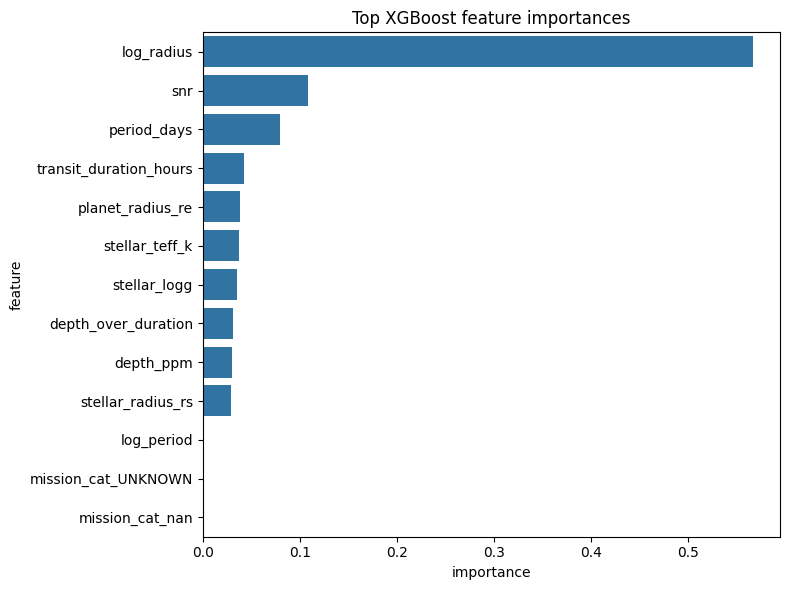

/tmp/ipython-input-3008325105.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, sample, show=True)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:7

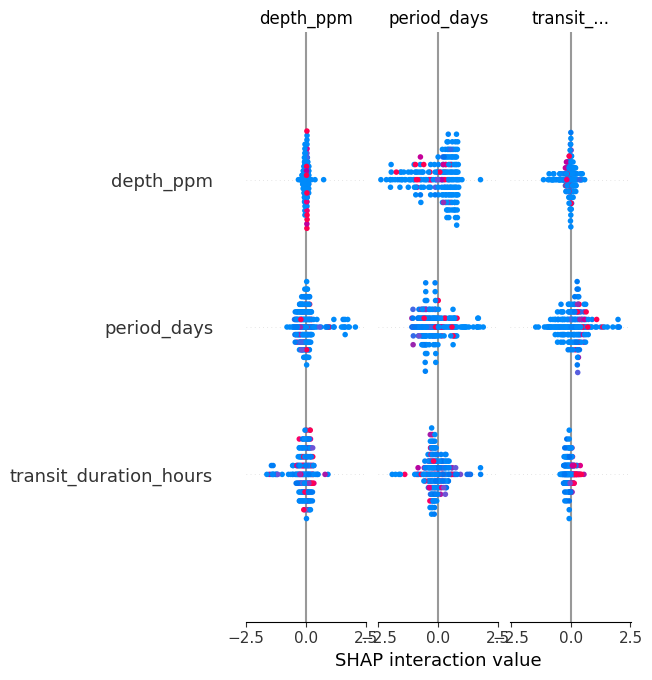

In [11]:
# Feature importance
importances = best_xgb.feature_importances_
feat_names = X_train_scaled.columns
fi = pd.DataFrame({"feature": feat_names, "importance": importances}).sort_values("importance", ascending=False).head(30)
plt.figure(figsize=(8,6))
sns.barplot(data=fi, x="importance", y="feature")
plt.title("Top XGBoost feature importances")
plt.tight_layout()
plt.show()

# SHAP
explainer = shap.TreeExplainer(best_xgb)
# pick a small sample from validation for plotting
sample = X_val_scaled.sample(n=min(200, len(X_val_scaled)), random_state=SEED)
shap_values = explainer.shap_values(sample)
# summary plot (will render in notebook)
shap.summary_plot(shap_values, sample, show=True)

In [13]:
# =====================================================
# CELL 10 — Prepare light-curve pipeline (phase-folding)
# Fully robust: auto-detect period, target_id, label
# =====================================================

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from lightkurve import search_lightcurve
import math

SEED = 42
np.random.seed(SEED)

# -------------------------------
# Ensure df has a valid period column
# -------------------------------
period_candidates = ["period_days", "period", "pl_orbper", "koi_period"]
period_col = None
for c in period_candidates:
    if c in df.columns:
        period_col = c
        break
if period_col is None:
    raise KeyError("No period column found in df. Checked: " + ", ".join(period_candidates))
if period_col != "period_days":
    df["period_days"] = df[period_col]

# -------------------------------
# Ensure df has a valid target_id column
# -------------------------------
target_candidates = ["target_id", "kepid", "kepoi_name", "pl_name", "pl_hostname", "toi", "tic_id"]
target_col = None
for c in target_candidates:
    if c in df.columns:
        target_col = c
        break
if target_col is None:
    raise KeyError("No target_id column found in df. Checked: " + ", ".join(target_candidates))
if target_col != "target_id":
    df["target_id"] = df[target_col]

# -------------------------------
# Ensure df has a valid label column
# -------------------------------
if "label" not in df.columns:
    # Map disposition_std to numeric labels
    # CONFIRMED=2, CANDIDATE=1, FALSE_POSITIVE=0, AMBIGUOUS=np.nan
    label_map = {"FALSE_POSITIVE":0, "CANDIDATE":1, "CONFIRMED":2}
    df["label"] = df.get("disposition_std", pd.Series([np.nan]*len(df))).map(label_map)

# -------------------------------
# Utility: create phase-folded vector
# -------------------------------
def make_phase_folded_vector(time, flux, period, t0=None, bins=400, fold_window=0.1):
    if t0 is None:
        t0 = time[0]

    phase = ((time - t0 + 0.5 * period) % period) / period
    phase = phase - 0.5

    mask = np.abs(phase) <= fold_window
    phases = phase[mask]
    fluxes = flux[mask]

    if len(phases) < 10:
        phase_all = ((time - t0 + 0.5 * period) % period) / period - 0.5
        phases = phase_all
        fluxes = flux

    order = np.argsort(phases)
    phases, fluxes = phases[order], fluxes[order]

    bin_edges = np.linspace(-fold_window, fold_window, bins + 1)
    digitized = np.digitize(phases, bin_edges) - 1
    binned = np.zeros(bins)
    counts = np.zeros(bins)
    for i, d in enumerate(digitized):
        if 0 <= d < bins:
            binned[d] += fluxes[i]
            counts[d] += 1
    counts[counts == 0] = 1
    binned = binned / counts

    binned = (binned - np.nanmedian(binned)) / (np.nanstd(binned) + 1e-9)
    return binned

# ----------------------------------
# Phase-fold a subset of known targets
# ----------------------------------
phase_rows = df[df["period_days"].notna() & df["target_id"].notna()].sample(
    n=min(120, len(df[df["period_days"].notna() & df["target_id"].notna()])),
    random_state=SEED
)

phase_vectors = []
phase_labels = []
failed = 0

for idx, row in tqdm(phase_rows.iterrows(), total=len(phase_rows), desc="Phase folding"):
    pid = row["target_id"]
    period = row["period_days"]
    label = row["label"] if not pd.isna(row["label"]) else 1  # fallback: CANDIDATE=1

    try:
        period = float(period)
        if not np.isfinite(period) or period <= 0:
            failed += 1
            continue

        # Search light curve
        q = search_lightcurve(str(pid))
        lc_obj = q.download() if q is not None else None
        if lc_obj is None:
            res_all = q.download_all() if q is not None else None
            lc_obj = res_all[0] if res_all else None
        if lc_obj is None:
            raise ValueError("No light curve found for target.")

        # Extract usable LightCurve
        if hasattr(lc_obj, "PDCSAP_FLUX") and lc_obj.PDCSAP_FLUX is not None:
            lc = lc_obj.PDCSAP_FLUX.remove_nans()
        elif hasattr(lc_obj, "SAP_FLUX") and lc_obj.SAP_FLUX is not None:
            lc = lc_obj.SAP_FLUX.remove_nans()
        else:
            lc = getattr(lc_obj, "remove_nans", lambda: lc_obj)()

        if len(lc.time.value) < 5 or len(lc.flux.value) < 5:
            failed += 1
            continue

        vec = make_phase_folded_vector(
            lc.time.value, lc.flux.value, period, bins=400, fold_window=0.05
        )
        phase_vectors.append(vec)
        phase_labels.append(int(label))

    except Exception as e:
        failed += 1
        continue

print(f"Extracted {len(phase_vectors)} vectors; failed: {failed}")

# Convert to arrays
if len(phase_vectors) > 0:
    X_phase = np.vstack(phase_vectors)
    y_phase = np.array(phase_labels)
    print("Phase array shape:", X_phase.shape)
else:
    X_phase = None
    y_phase = None

/usr/local/lib/python3.12/dist-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


Phase folding:   0%|          | 0/120 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 66 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/tmp/ipython-input-2820106167.py:121: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  if hasattr(lc_obj, "PDCSAP_FLUX") and lc_obj.PDCSAP_FLUX is not None:
/tmp/ipython-input-2820106167.py:122: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lc_obj.PDCSAP_FLUX.remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 11 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warning

Extracted 120 vectors; failed: 0
Phase array shape: (120, 400)


/tmp/ipython-input-2820106167.py:121: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  if hasattr(lc_obj, "PDCSAP_FLUX") and lc_obj.PDCSAP_FLUX is not None:
/tmp/ipython-input-2820106167.py:122: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lc_obj.PDCSAP_FLUX.remove_nans()


In [14]:
# =====================================================
# SAVE/LOAD PHASE-FOLDED DATA (to skip re-downloading)
# =====================================================
import numpy as np
import os

SAVE_PATH = "phase_folded_data.npz"

# --- Save results if available ---
if X_phase is not None and y_phase is not None:
    np.savez_compressed(SAVE_PATH, X_phase=X_phase, y_phase=y_phase)
    print(f"✅ Saved phase-folded dataset to {SAVE_PATH} ({X_phase.shape[0]} samples).")

# --- Reload if file exists ---
elif os.path.exists(SAVE_PATH):
    data = np.load(SAVE_PATH)
    X_phase = data["X_phase"]
    y_phase = data["y_phase"]
    print(f"✅ Loaded saved phase-folded data: {X_phase.shape[0]} samples, {X_phase.shape[1]} bins.")
else:
    print("⚠️ No phase-folded data found. Run the extraction cell first.")

✅ Saved phase-folded dataset to phase_folded_data.npz (120 samples).


In [17]:
# Only run this cell if X_phase is not None and you have GPU enabled
if X_phase is not None:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    class PhaseDataset(Dataset):
        def __init__(self, X, y):
            self.X = X.astype(np.float32)
            self.y = y.astype(np.int64)
        def __len__(self):
            return len(self.X)
        def __getitem__(self, idx):
            return torch.from_numpy(self.X[idx]).unsqueeze(0), torch.tensor(self.y[idx])

    # split train/val
    X_tr, X_va, y_tr, y_va = train_test_split(X_phase, y_phase, test_size=0.2, stratify=y_phase, random_state=SEED)
    train_ds = PhaseDataset(X_tr, y_tr)
    val_ds = PhaseDataset(X_va, y_va)
    bs = 32
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=2)

    class CNN1D(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv1d(1, 32, kernel_size=9, padding=4)
            self.bn1 = nn.BatchNorm1d(32)
            self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
            self.bn2 = nn.BatchNorm1d(64)
            self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
            self.pool = nn.AdaptiveAvgPool1d(1)
            self.fc1 = nn.Linear(128, 128)
            self.fc2 = nn.Linear(128, 3)
        def forward(self, x):
            x = F.relu(self.bn1(self.conv1(x)))
            x = F.relu(self.bn2(self.conv2(x)))
            x = F.relu(self.conv3(x))
            x = self.pool(x).squeeze(-1)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return x

    model_cnn = CNN1D().to(device)
    optimizer = torch.optim.AdamW(model_cnn.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    best_val_f1 = 0.0
    for epoch in range(1, 301):
        model_cnn.train()
        train_losses = []
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            logits = model_cnn(xb)
            loss = criterion(logits, yb)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            train_losses.append(loss.item())
        # val
        model_cnn.eval()
        preds = []
        ys = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                logits = model_cnn(xb)
                preds.append(torch.argmax(logits, dim=1).cpu().numpy())
                ys.append(yb.numpy())
        preds = np.concatenate(preds)
        ys = np.concatenate(ys)
        f1 = f1_score(ys, preds, average="macro")
        print(f"Epoch {epoch} train_loss={np.mean(train_losses):.4f} val_f1={f1:.4f}")
        if f1 > best_val_f1:
            best_val_f1 = f1
            torch.save(model_cnn.state_dict(), ARTIFACTS / "cnn_phase_best.pth")
    print("Best val f1:", best_val_f1)
else:
    print("Phase-folded data not available. Skipping CNN training.")

Epoch 1 train_loss=1.0952 val_f1=0.3081
Epoch 2 train_loss=1.0189 val_f1=0.2222
Epoch 3 train_loss=0.9998 val_f1=0.2222
Epoch 4 train_loss=0.9871 val_f1=0.2222
Epoch 5 train_loss=0.9805 val_f1=0.4588
Epoch 6 train_loss=0.9773 val_f1=0.4588
Epoch 7 train_loss=0.9654 val_f1=0.4588
Epoch 8 train_loss=0.9607 val_f1=0.4588
Epoch 9 train_loss=0.9450 val_f1=0.4110
Epoch 10 train_loss=0.9477 val_f1=0.4110
Epoch 11 train_loss=0.9319 val_f1=0.4110
Epoch 12 train_loss=0.9325 val_f1=0.4110
Epoch 13 train_loss=0.9236 val_f1=0.4110
Epoch 14 train_loss=0.9092 val_f1=0.4110
Epoch 15 train_loss=0.8994 val_f1=0.4110
Epoch 16 train_loss=0.8834 val_f1=0.4110
Epoch 17 train_loss=0.8892 val_f1=0.3817
Epoch 18 train_loss=0.8617 val_f1=0.4110
Epoch 19 train_loss=0.8554 val_f1=0.4110
Epoch 20 train_loss=0.8510 val_f1=0.4110
Epoch 21 train_loss=0.8347 val_f1=0.3556
Epoch 22 train_loss=0.8221 val_f1=0.3817
Epoch 23 train_loss=0.8295 val_f1=0.3817
Epoch 24 train_loss=0.8172 val_f1=0.3817
Epoch 25 train_loss=0.772

In [18]:
# Predict probs with XGBoost on validation and test sets
xgb_val_probs = best_xgb.predict_proba(X_val_scaled)
xgb_test_probs = best_xgb.predict_proba(X_test_scaled)

# Create meta training data: use XGB predictions on val set as features
meta_X = pd.DataFrame(xgb_val_probs, columns=["xgb_prob_0","xgb_prob_1","xgb_prob_2"]).reset_index(drop=True)
meta_y = y_val.reset_index(drop=True)

# If CNN exists, compute CNN probs for same IDs (only possible if we extracted LC for same targets)
# For simplicity, we will only use XGB meta features in this notebook. If you have CNN predictions aligned, append them.

# Meta learner
meta = LogisticRegression(multi_class="multinomial", max_iter=1000)
meta.fit(meta_X, meta_y)
joblib.dump(meta, ARTIFACTS / "meta_logreg.joblib")
print("Trained meta learner and saved.")

Trained meta learner and saved.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Stacked model classification report on test:
              precision    recall  f1-score   support

           0     0.8446    0.8840    0.8638       793
           1     0.6355    0.5000    0.5597       272
           2     0.8131    0.8443    0.8284       546

    accuracy                         0.8057      1611
   macro avg     0.7644    0.7428    0.7506      1611
weighted avg     0.7986    0.8057    0.8005      1611



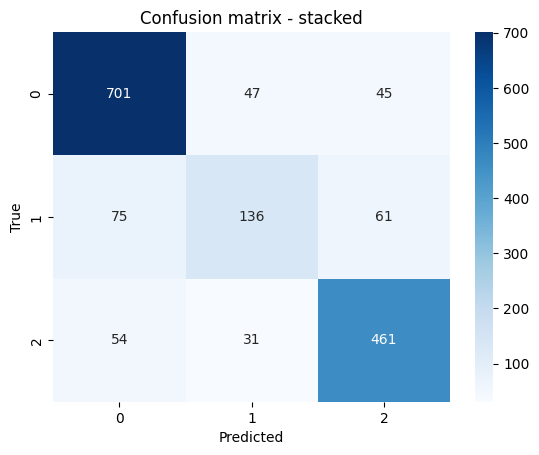

Saved final models.


In [19]:
# XGB probs on test
meta_test_X = pd.DataFrame(xgb_test_probs, columns=["xgb_prob_0","xgb_prob_1","xgb_prob_2"])
meta_y_test = y_test.reset_index(drop=True)
meta_preds = meta.predict(meta_test_X)
print("Stacked model classification report on test:")
print(classification_report(meta_y_test, meta_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(meta_y_test, meta_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion matrix - stacked")
plt.show()

# Save final artifacts
joblib.dump(best_xgb, ARTIFACTS / "xgb_tabular_final.joblib")
joblib.dump(scaler, ARTIFACTS / "scaler_final.joblib")
print("Saved final models.")

In [49]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import RobustScaler

# -----------------------------
# Load artifacts
# -----------------------------
xgb_clf = joblib.load("./exosphereai/artifacts/xgb_tabular.joblib")
scaler = joblib.load("./exosphereai/artifacts/scaler_robust.joblib")
print("✅ Model and scaler loaded.")

# -----------------------------
# Define numeric features (same as training)
# -----------------------------
numeric_features = [
    "period_days", "transit_duration_hours", "depth_ppm", "planet_radius_re",
    "stellar_radius_rs", "stellar_teff_k", "stellar_logg", "snr",
    "log_period", "log_radius", "depth_over_duration"
]

# -----------------------------
# Preprocessing function
# -----------------------------
def preprocess_df(df):
    df_proc = df.copy()

    # Ensure numeric
    df_proc[numeric_features] = df_proc[numeric_features].apply(pd.to_numeric, errors="coerce")
    df_proc["num_numeric"] = df_proc[numeric_features].notna().sum(axis=1)
    df_proc = df_proc[df_proc["num_numeric"] >= 3]

    # Mission category
    df_proc["mission_cat"] = df_proc["mission_cat"].replace(["", "NaN", None, np.nan], "UNKNOWN")
    df_proc["mission_cat"] = df_proc["mission_cat"].astype(str).fillna("UNKNOWN")

    # Select numeric + categorical features
    X_raw = df_proc[numeric_features + ["mission_cat"]].copy()

    # One-hot mission_cat (dummy_na=True)
    X = pd.get_dummies(X_raw, columns=["mission_cat"], dummy_na=True)

    # Align with training columns
    # This ensures all columns expected by XGBoost exist (add missing, drop extra)
    training_cols = xgb_clf.get_booster().feature_names  # saved columns from training
    for col in training_cols:
        if col not in X.columns:
            X[col] = 0
    X = X[training_cols]

    # Scale numeric
    X[numeric_features] = scaler.transform(X[numeric_features].fillna(0))

    return X, df_proc

# -----------------------------
# Apply preprocessing
# -----------------------------
X_processed, df_clean = preprocess_df(df)

# -----------------------------
# Optional: evaluation
# -----------------------------
y = df_clean["label"].astype(int)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

acc = xgb_clf.score(X_test, y_test)
print(f"🎯 Test Accuracy: {acc:.4f}")

✅ Model and scaler loaded.
🎯 Test Accuracy: 0.7890


SHAP values shape: (1611, 13, 3)


/tmp/ipython-input-1671198284.py:36: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, class_idx], X_test_scaled)


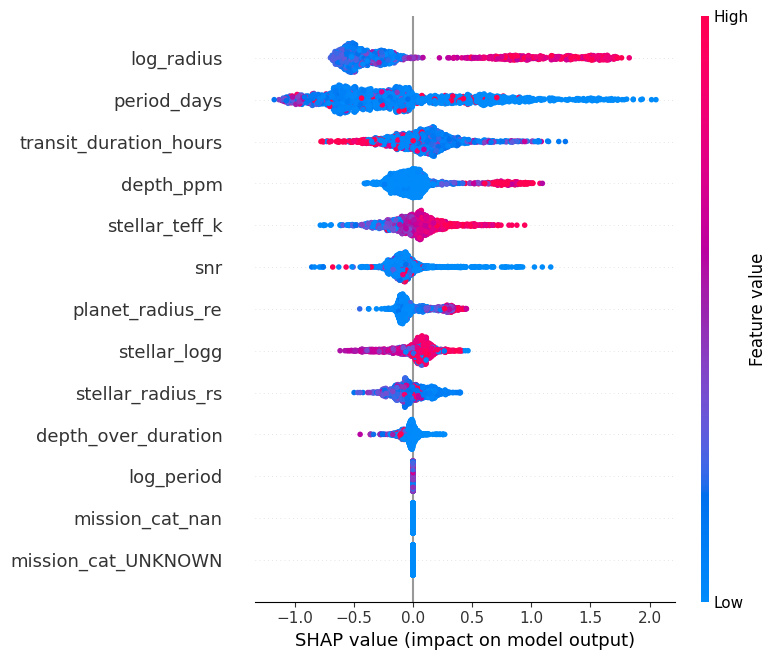

/tmp/ipython-input-1671198284.py:39: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, class_idx], X_test_scaled, plot_type="bar")


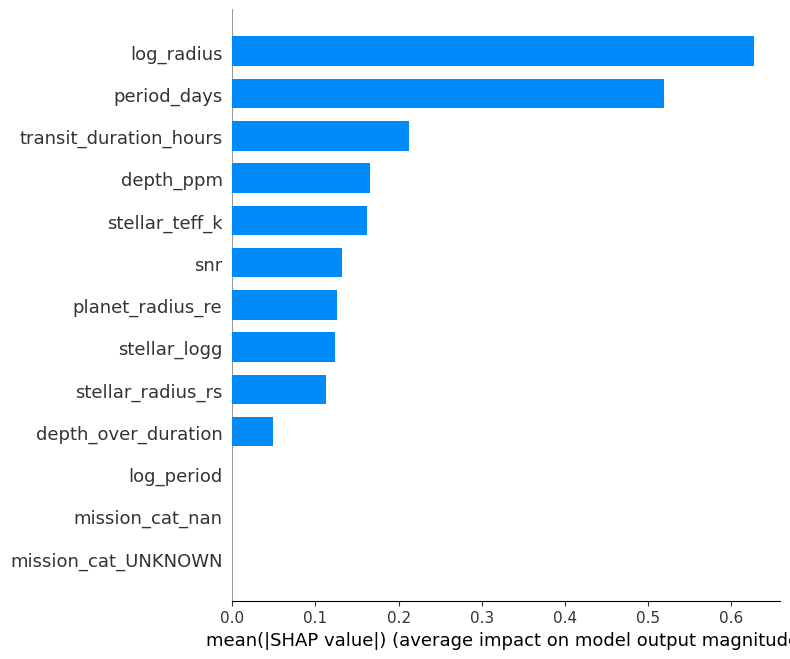

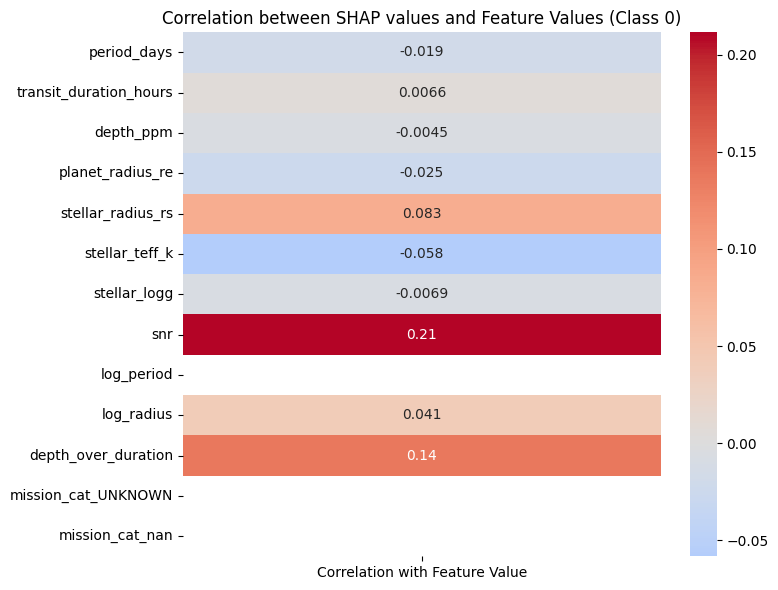

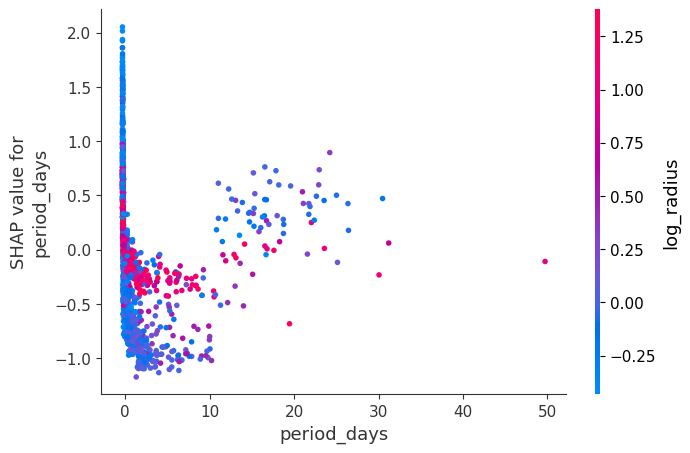

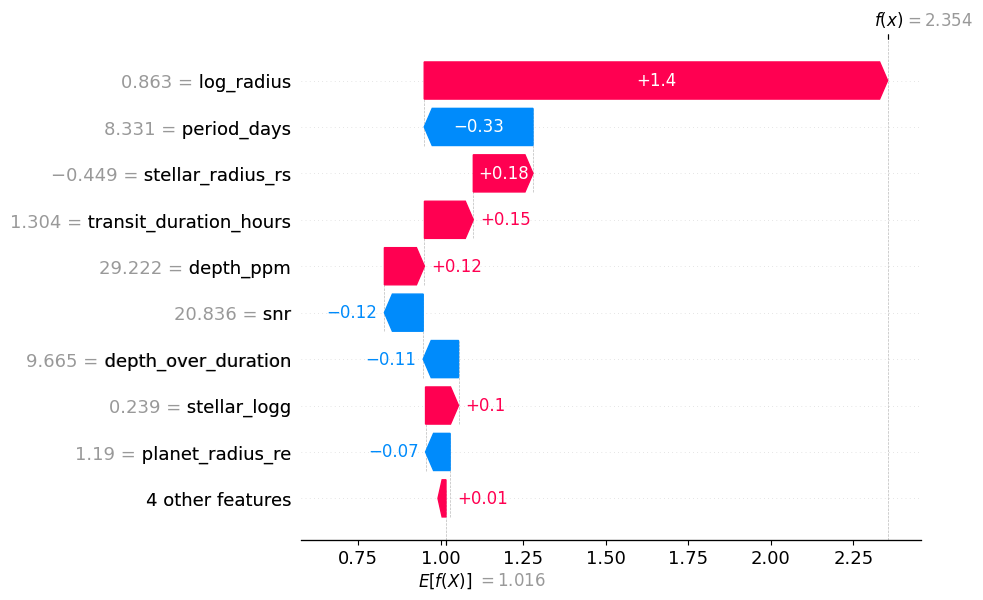

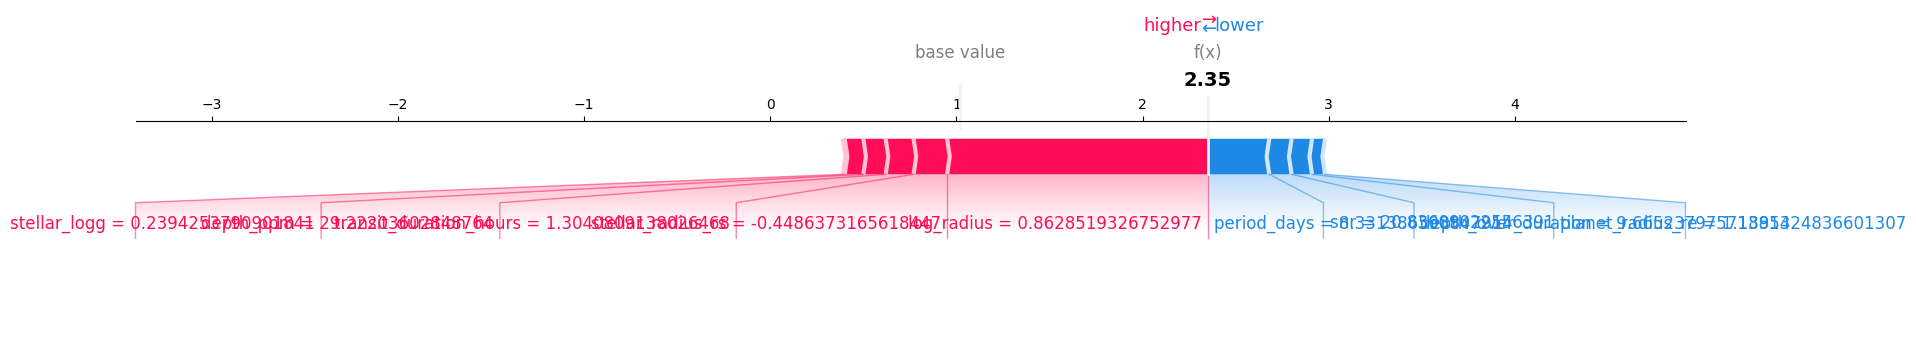

<Figure size 640x480 with 0 Axes>

In [75]:
# ==========================================
# SHAP Explainability for XGBoost Classifier
# ==========================================
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: for interactive force plots in Jupyter
shap.initjs()

# ------------------------------------------------------------------
# 1. Create SHAP Explainer and Compute SHAP Values
# ------------------------------------------------------------------
explainer = shap.TreeExplainer(xgb_clf)

# shap_values shape -> (n_samples, n_features, n_classes)
shap_values = explainer.shap_values(X_test_scaled)
print("SHAP values shape:", np.shape(shap_values))

# If using pandas DataFrame, keep column names
if hasattr(X_test_scaled, "columns"):
    feat_names = X_test_scaled.columns
else:
    feat_names = [f"Feature_{i}" for i in range(X_test_scaled.shape[1])]

# Choose which class to explore
class_idx = 0      # can be 0, 1, 2, ... for multiclass
sample_idx = 0     # which test instance to visualize

# ------------------------------------------------------------------
# 2. Global Explainability
# ------------------------------------------------------------------

# Beeswarm plot
shap.summary_plot(shap_values[:, :, class_idx], X_test_scaled)

# Bar plot of mean(|SHAP|)
shap.summary_plot(shap_values[:, :, class_idx], X_test_scaled, plot_type="bar")

# ------------------------------------------------------------------
# Correlation Heatmap between SHAP values and features
# ------------------------------------------------------------------
import pandas as pd

# Make DataFrame for easier analysis
shap_df = pd.DataFrame(shap_values[:, :, class_idx], columns=feat_names)
X_df = pd.DataFrame(X_test_scaled, columns=feat_names) \
        if not hasattr(X_test_scaled, 'columns') else X_test_scaled.copy()

# Compute correlation between SHAP importance and feature values
corr_matrix = shap_df.corrwith(X_df)

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix.to_frame(name="Correlation with Feature Value"),
            annot=True, cmap="coolwarm", center=0)
plt.title(f"Correlation between SHAP values and Feature Values (Class {class_idx})")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 3. Dependence plot for a chosen feature
# ------------------------------------------------------------------
feature_to_plot = feat_names[0]   # or a specific column name
shap.dependence_plot(feature_to_plot, shap_values[:, :, class_idx], X_test_scaled)

# ------------------------------------------------------------------
# 4. Local Explainability for a single instance
# ------------------------------------------------------------------

# Pick one test sample
row = X_test_scaled.iloc[sample_idx] if hasattr(X_test_scaled, 'iloc') else X_test_scaled[sample_idx]

# Get shap values for that single sample & class
single_expl = shap_values[sample_idx, :, class_idx]

# Waterfall plot
shap.waterfall_plot(
    shap.Explanation(values=single_expl,
                     base_values=explainer.expected_value[class_idx],
                     data=row)
)

# ------------------------------------------------------------------
# 5. Interactive Force Plot (works best in Jupyter Notebook)
# ------------------------------------------------------------------
# Round SHAP values and feature values
shap_vals_rounded = shap_values[sample_idx, :, class_idx].round(2)

if hasattr(row, "copy"):     # pandas Series
    row_rounded = row.copy().round(2)
else:                        # numpy array
    row_rounded = np.round(row, 2)

# Now plot
shap.force_plot(
    base_value = round(explainer.expected_value[class_idx], 2),
    shap_values = shap_vals_rounded,
    features = row_rounded,
    matplotlib = True
)


# Change background to white
plt.gcf().set_facecolor('white')
plt.show()


In [68]:
print("Artifacts saved to:", ARTIFACTS)
!ls -l /content/exosphereai/artifacts

# Create a zip of artifacts for download
!zip -r /content/exosphereai_artifacts.zip /content/exosphereai/artifacts
print("Artifacts zipped to /content/exosphereai_artifacts.zip")

Artifacts saved to: /content/exosphereai/artifacts
total 4372
-rw-r--r-- 1 root root  217565 Oct  5 03:01 cnn_phase_best.pth
-rw-r--r-- 1 root root    1263 Oct  5 03:03 meta_logreg.joblib
-rw-r--r-- 1 root root    1103 Oct  5 03:05 scaler_final.joblib
-rw-r--r-- 1 root root    1103 Oct  5 04:26 scaler_robust.joblib
-rw-r--r-- 1 root root 2119863 Oct  5 03:05 xgb_tabular_final.joblib
-rw-r--r-- 1 root root 2119863 Oct  5 04:18 xgb_tabular.joblib
  adding: content/exosphereai/artifacts/ (stored 0%)
  adding: content/exosphereai/artifacts/xgb_tabular.joblib (deflated 63%)
  adding: content/exosphereai/artifacts/cnn_phase_best.pth (deflated 10%)
  adding: content/exosphereai/artifacts/xgb_tabular_final.joblib (deflated 63%)
  adding: content/exosphereai/artifacts/scaler_final.joblib (deflated 32%)
  adding: content/exosphereai/artifacts/scaler_robust.joblib (deflated 32%)
  adding: content/exosphereai/artifacts/meta_logreg.joblib (deflated 40%)
Artifacts zipped to /content/exosphereai_arti